## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```

We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [56]:
SEED = 1

In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv")
df.columns = df.columns.str.replace(" ", "_").str.lower()


In [6]:
features = ["make", "model", "year", "engine_hp", "engine_cylinders", "transmission_type", "vehicle_style", "highway_mpg", "city_mpg"]
df = df[features+["msrp"]]
df

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,46120
11910,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,56670
11911,Acura,ZDX,2012,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50620
11912,Acura,ZDX,2013,300.0,6.0,AUTOMATIC,4dr Hatchback,23,16,50920


In [7]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64

In [10]:
df = df.fillna(0)
df.isnull().sum()

make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64

In [14]:
df["above_average"] = (df.msrp > df.msrp.mean()).astype(int)
df.above_average.value_counts()

above_average
0    8645
1    3269
Name: count, dtype: int64

In [20]:
df_fulltrain, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_fulltrain, test_size=0.25, random_state=1)

df.shape[0]*0.6, df.shape[0]*0.2, df_train.shape, df_val.shape, df_test.shape

(7148.4, 2382.8, (7148, 11), (2383, 11), (2383, 11))



### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`


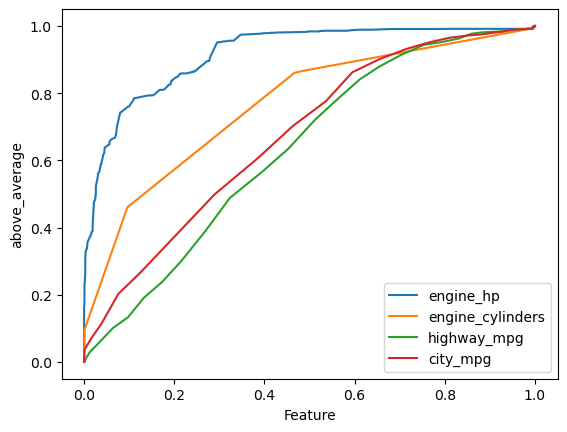

In [49]:
numerical_features = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

feature_inverters = {
    "engine_hp": 1,
    "engine_cylinders": 1,
    "highway_mpg": -1,
    "city_mpg": -1
}

for feat in numerical_features:
    fpr, tpr, thresholds = roc_curve(
        df_train["above_average"], 
        df_train[feat]*feature_inverters[feat]
    )
    plt.plot(fpr, tpr,  label=feat)
    

plt.xlabel('Feature')
plt.ylabel("above_average")

plt.legend()

In [51]:
for feat in numerical_features:
    score = roc_auc_score(
        df_train["above_average"], 
        df_train[feat]*feature_inverters[feat]
    )
    print(f"feature: {feat},\tscore: {score}")

feature: engine_hp,	score: 0.9171031265539011
feature: engine_cylinders,	score: 0.766116490165669
feature: highway_mpg,	score: 0.6330587871772013
feature: city_mpg,	score: 0.6734244643245233



### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979


0.976

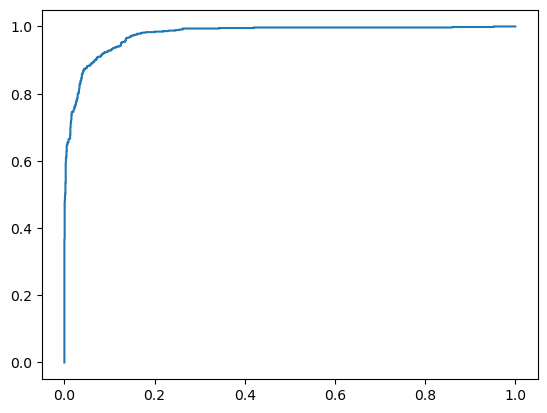

In [103]:
from sklearn.linear_model import LogisticRegression


dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient="records")

X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=SEED)

model.fit(X_train, df_train["above_average"])

val_dict = df_val[features].to_dict(orient="records")

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
# score = accuracy_score(df_val["above_average"], y_pred)

fpr, tpr, thresholds = roc_curve(
    df_val["above_average"], 
    y_pred
)
plt.plot(fpr, tpr)

auc = roc_auc_score(df_val["above_average"], y_pred)
round(auc, 3)



### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


In [68]:
def evaluate(threshold, y_pred, y_val):
    predict_positive = y_pred >= threshold
    predict_negative = y_pred < threshold

    actual_positive = y_val == 1
    actual_negative = y_val == 0

    tp = (actual_positive & predict_positive).sum()
    fp = (actual_negative & predict_positive).sum()

    fn = (actual_positive & predict_negative).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall
    

In [104]:
df_thresholds = pd.DataFrame()
thresholds = list()
precisions = list()
recalls = list()

for threshold in np.arange(0, 1, 0.01):
    precision, recall = evaluate(threshold, y_pred, df_val["above_average"])
    thresholds.append(threshold)
    precisions.append(precision)
    recalls.append(recall)

df_thresholds["threshold"] = thresholds
df_thresholds["precision"] = precisions
df_thresholds["recall"] = recalls

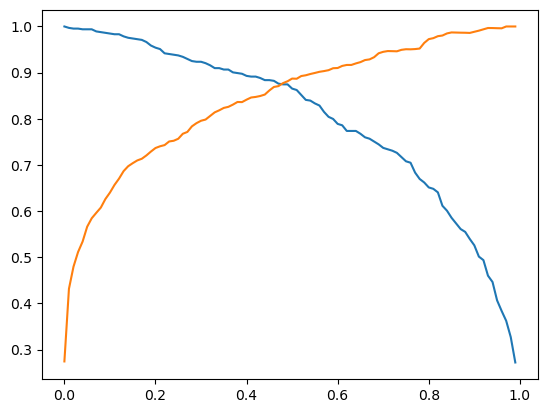

In [107]:
plt.plot(df_thresholds.threshold, df_thresholds.recall)
plt.plot(df_thresholds.threshold, df_thresholds.precision)



### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72



In [117]:
df_thresholds["F1"] = 2*(df_thresholds.recall*df_thresholds.precision/(df_thresholds.recall+df_thresholds.precision))
df_thresholds[df_thresholds["F1"] == df_thresholds["F1"].max()]

,threshold,precision,recall,F1
49,0.49,0.881356,0.874618,0.877974


In [120]:
df_thresholds[df_thresholds.threshold.isin([0.12, 0.32, 0.52, 0.72])]

,threshold,precision,recall,F1
12,0.12,0.670490,0.983180,0.797272
32,0.32,0.806191,0.915902,0.857552
52,0.52,0.892628,0.851682,0.871674
72,0.72,0.946535,0.730887,0.824849



### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140


In [121]:
!pip install tqdm

  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 4.6 MB/s eta 0:00:00


In [123]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [135]:
def train(df_train, y_true):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient="records")

    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=SEED)

    model.fit(X_train, y_true)

    return dv, model

def predict(df_val, dv, model):
    val_dict = df_val.to_dict(orient="records")

    X_val = dv.transform(val_dict)

    y_pred = model.predict_proba(X_val)[:, 1]
    
    return y_pred

In [138]:
def kfold_cross_validation(df_fulltrain):
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

    scores = []
    for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train(df_train[features], y_train)
        y_pred = predict(df_val[features], dv, model)

        auc = roc_auc_score(y_val, y_pred)

        scores.append(auc)

    return np.mean(scores), np.std(scores)

In [139]:
kfold_cross_validation(df_fulltrain)

(0.979824670114182, 0.0027973189410986795)



### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.


In [129]:
def train_tunning(df_train, y_true, C):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient="records")

    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000, random_state=SEED)

    model.fit(X_train, y_true)

    return dv, model


In [133]:
def kfold_cross_validation_tunning(df_fulltrain, C):
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

    scores = []
    for train_idx, val_idx in kfold.split(df_fulltrain):
        df_train = df_fulltrain.iloc[train_idx]
        df_val = df_fulltrain.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average

        dv, model = train_tunning(df_train[features], y_train, C)
        y_pred = predict(df_val[features], dv, model)

        auc = roc_auc_score(y_val, y_pred)

        scores.append(auc)

    return np.mean(scores), np.std(scores)

In [134]:
Cs = [0.01, 0.1, 0.5, 10]

for C in Cs:
    mean, std = kfold_cross_validation_tunning(df_fulltrain, C)
    print(f"C={C}\t Mean={mean:.{3}f}\t STD={std:.3f}")

C=0.01	 Mean=0.952	 STD=0.002
C=0.1	 Mean=0.972	 STD=0.002
C=0.5	 Mean=0.978	 STD=0.001
C=10	 Mean=0.983	 STD=0.003




## Submit the results

- Submit your results here: https://forms.gle/E7Fa3WuBw3HkPQYg6
- If your answer doesn't match options exactly, select the closest one.
- You can submit your solution multiple times. In this case, only the last submission will be used

## Deadline

The deadline for submitting is October 9 (Monday), 23:00 CET. After that the form will be closed.
